In [50]:
import numpy as np
import scipy.stats as s
import empiricaldist as ed
import matplotlib.pyplot as plt
from collections import Counter
from utils import decorate
import pandas as pd

In classical statistical inference, the usual tool for this scenario is a Student’s t-test, and the result is a p-value. This process is an example of null hypothesis significance testing.

A Bayesian alternative is to compute the posterior distribution of the difference between the groups. Then we can use that distribution to answer whatever questions we are interested in, including the most likely size of the difference, a credible interval that’s likely to contain the true difference, the probability of superiority, or the probability that the difference exceeds some threshold.

In [2]:
df = pd.read_csv('drp_scores.csv', sep='\\t')
df.head()

/tmp/ipykernel_10496/1084617686.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('drp_scores.csv', sep='\\t')


,Treatment,Response
0,Treated,24
1,Treated,43
2,Treated,58
3,Treated,71
4,Treated,43


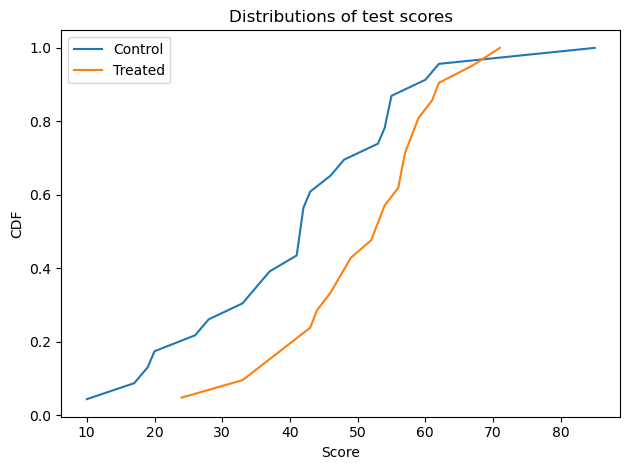

In [3]:
grouped = df.groupby('Treatment')
responses = {}

for name, group in grouped:
    responses[name] = group['Response']

for name, response in responses.items():
    cdf = ed.Cdf.from_seq(response)
    cdf.plot(label=name)
    
decorate(xlabel='Score', 
         ylabel='CDF',
         title='Distributions of test scores')

In [4]:
grouped.agg(s=('Response', 'mean'))

,s
Treatment,
Control,41.521739
Treated,51.476190


There is overlap between the distributions, but it looks like the scores are higher in the treated group. The distribution of scores is not exactly normal for either group, but it is close enough that the normal model is a reasonable choice.

So I’ll assume that in the entire population of students (not just the ones in the experiment), the distribution of scores is well modeled by a normal distribution with unknown mean and standard deviation. I’ll use mu and sigma to denote these unknown parameters, and we’ll do a Bayesian update to estimate what they are.

### Estimating Parameters

In [5]:

def make_uniform(qs, name=None, **options):
    """Make a Pmf that represents a uniform distribution."""
    pmf = ed.Pmf(1.0, qs, **options)
    pmf.normalize()
    if name:
        pmf.index.name = name
    return pmf

In [6]:
qs = np.linspace(20, 80, num=101)
prior_mu = make_uniform(qs, name='mean')

qs = np.linspace(5, 30, num=101)
prior_sigma = make_uniform(qs, name='std')

In [7]:
from utils import make_joint

prior = make_joint(prior_mu, prior_sigma)

### Likelihood

We would like to know the probability of each score in the dataset for each hypothetical pair of values, mu and sigma. I’ll do that by making a 3-dimensional grid with values of mu on the first axis, values of sigma on the second axis, and the scores from the dataset on the third axis.

In [8]:
mu_mesh, sigma_mesh, data_mesh = np.meshgrid(
    prior.columns, prior.index, responses['Control'])

mu_mesh.shape

(101, 101, 23)

In [9]:
densities = s.norm(mu_mesh, sigma_mesh).pdf(data_mesh)
densities.shape

(101, 101, 23)

In [10]:
a = np.array(
    [[2,2,2],
    [3,3,3],
    [4,4,4]]
)
b = np.array([a*0.5, a, a*2])
b.shape

(3, 3, 3)

In [11]:
b

array([[[1. , 1. , 1. ],
        [1.5, 1.5, 1.5],
        [2. , 2. , 2. ]],

       [[2. , 2. , 2. ],
        [3. , 3. , 3. ],
        [4. , 4. , 4. ]],

       [[4. , 4. , 4. ],
        [6. , 6. , 6. ],
        [8. , 8. , 8. ]]])

In [12]:
b.prod(axis=2)

array([[  1.   ,   3.375,   8.   ],
       [  8.   ,  27.   ,  64.   ],
       [ 64.   , 216.   , 512.   ]])

In [13]:
densities[0, 0, :]

array([4.98849426e-06, 2.02817041e-06, 1.82694408e-12, 3.88372110e-02,
       3.80216308e-17, 2.46443834e-04, 2.71659385e-03, 1.17886136e-05,
       7.82085388e-02, 7.26192300e-12, 7.97884561e-02, 1.59976555e-38,
       1.07220707e-07, 1.07981933e-02, 6.66449206e-02, 1.01045422e-15,
       2.77335999e-11, 4.98849426e-06, 2.46443834e-04, 4.98849426e-06,
       1.82694408e-12, 2.21841669e-02, 1.23652410e-08])

In [14]:
print(len(df))
print(densities[0, 0, :].shape)

44
(23,)


In [15]:
grouped.agg(n=('Response', len))

,n
Treatment,
Control,23
Treated,21


The result is a 3-D array. To compute likelihoods, I’ll multiply these densities along axis=2, which is the axis of the data. The result is a 2-D array that contains the likelihood of the entire dataset for each hypothetical pair of parameters.

We can use this array to update the prior.

In [16]:
likelihood = densities.prod(axis=2)
likelihood.shape

(101, 101)

In [17]:
from utils import normalize

# The result is a DataFrame that represents the joint posterior distribution.
posterior = prior * likelihood
normalize(posterior)
posterior.shape

(101, 101)

In [18]:
posterior

mean,20.0,20.6,21.2,21.8,22.4,23.0,23.6,24.2,24.8,25.4,...,74.6,75.2,75.8,76.4,77.0,77.6,78.2,78.8,79.4,80.0
std,,,,,,,,,,,,,,,,,,,,,
5.00,5.677808e-135,6.945124e-130,6.100156e-125,3.847366e-120,1.742400e-115,5.666224e-111,1.323127e-106,2.218557e-102,2.671171e-98,2.309374e-94,...,4.996247e-261,4.975708e-269,3.556843e-277,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
5.25,1.242201e-121,5.113329e-117,1.558655e-112,3.518281e-108,5.880924e-104,7.279389e-100,6.672349e-96,4.528944e-92,2.276405e-88,8.472985e-85,...,5.729334e-236,3.164067e-243,1.293962e-250,3.918608e-258,8.787727e-266,1.459337e-273,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
5.50,4.116529e-110,6.592893e-106,8.030568e-102,7.439467e-98,5.241586e-94,2.808723e-90,1.144671e-86,3.547950e-83,8.363725e-80,1.499503e-76,...,2.731502e-214,6.658139e-221,1.234325e-227,1.740329e-234,1.866202e-241,1.521988e-248,9.440377e-256,4.453410e-263,1.597796e-270,4.356443e-278
5.75,4.231692e-100,2.974366e-96,1.627468e-92,6.932148e-89,2.298587e-85,5.933234e-82,1.192229e-78,1.864942e-75,2.270955e-72,2.152729e-69,...,2.043705e-195,1.819349e-201,1.260816e-207,6.801813e-214,2.856507e-220,9.338636e-227,2.376672e-233,4.708607e-240,7.261951e-247,8.718699e-254
6.00,2.386865e-91,8.143545e-88,2.207554e-84,4.754683e-81,8.136619e-78,1.106315e-74,1.195159e-71,1.025852e-68,6.996105e-66,3.790880e-63,...,6.906542e-179,1.916297e-184,4.224518e-190,7.399524e-196,1.029776e-201,1.138659e-207,1.000362e-213,6.982855e-220,3.872764e-226,1.706559e-232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29.00,3.181598e-08,4.506911e-08,6.321742e-08,8.780490e-08,1.207605e-07,1.644581e-07,2.217736e-07,2.961343e-07,3.915539e-07,5.126474e-07,...,5.694471e-12,3.292972e-12,1.885589e-12,1.069129e-12,6.002571e-13,3.337096e-13,1.837064e-13,1.001392e-13,5.405155e-14,2.888926e-14
29.25,3.105682e-08,4.373373e-08,6.099201e-08,8.424155e-08,1.152330e-07,1.561076e-07,2.094442e-07,2.782978e-07,3.662250e-07,4.772909e-07,...,6.437925e-12,3.757762e-12,2.172249e-12,1.243618e-12,7.051171e-13,3.959428e-13,2.201916e-13,1.212735e-13,6.614973e-14,3.573446e-14
29.50,3.023384e-08,4.232957e-08,5.870326e-08,8.063964e-08,1.097243e-07,1.478853e-07,1.974308e-07,2.610795e-07,3.419784e-07,4.437030e-07,...,7.231833e-12,4.259690e-12,2.485281e-12,1.436286e-12,8.221937e-13,4.662033e-13,2.618451e-13,1.456738e-13,8.027611e-14,4.381867e-14


In [19]:
def update_norm(prior, data):
    """Update the prior based on data."""
    mu_mesh, sigma_mesh, data_mesh = np.meshgrid(
        prior.columns, prior.index, data)
    
    densities = s.norm(mu_mesh, sigma_mesh).pdf(data_mesh)
    likelihood = densities.prod(axis=2)
    
    posterior = prior * likelihood
    normalize(posterior)

    return posterior

In [20]:
posterior_control = update_norm(prior, responses['Control'])
posterior_treated = update_norm(prior, responses['Treated'])

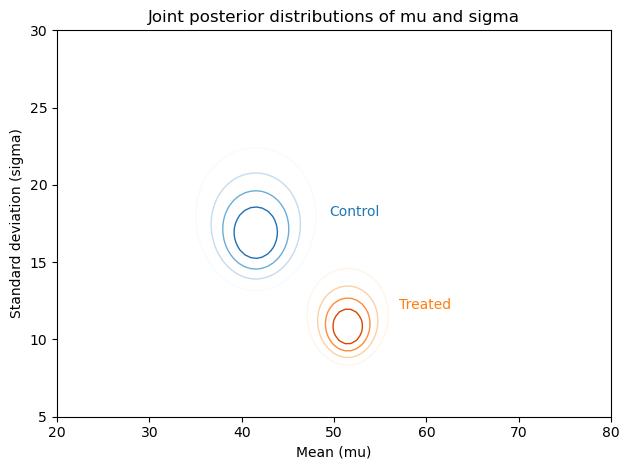

In [21]:
from utils import plot_contour

plot_contour(posterior_control, cmap='Blues')
plt.text(49.5, 18, 'Control', color='C0')

cs = plot_contour(posterior_treated, cmap='Oranges')
plt.text(57, 12, 'Treated', color='C1')

decorate(xlabel='Mean (mu)', 
         ylabel='Standard deviation (sigma)',
         title='Joint posterior distributions of mu and sigma')

Along the x-axis, it looks like the mean score for the treated group is higher. Along the y-axis, it looks like the standard deviation for the treated group is lower.

If we think the treatment causes these differences, the data suggest that the treatment increases the mean of the scores and decreases their spread. We can see these differences more clearly by looking at the marginal distributions for mu and sigma.

In [22]:
c_g = df[df['Treatment']=='Control']
t_g = df[df['Treatment']=='Treated']
xs = np.linspace(20, 100, 200)

control = s.norm(c_g['Response'].mean(), c_g['Response'].std()).pdf(xs)
treated = s.norm(t_g['Response'].mean(), t_g['Response'].std()).pdf(xs)

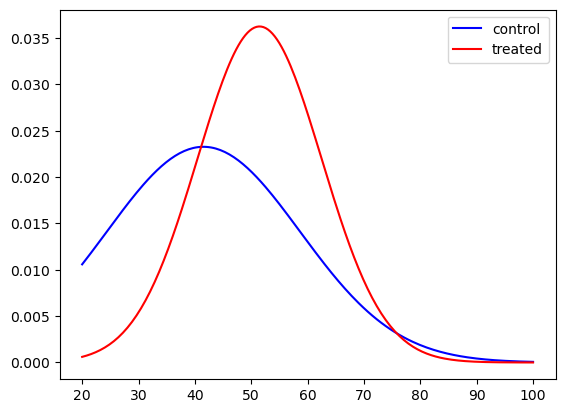

In [23]:
plt.plot(xs, control, label='control', color='blue')
plt.plot(xs, treated, label='treated', color='red')
plt.legend()
plt.show()

In [24]:
s.ttest_ind(c_g['Response'], t_g['Response'])

Ttest_indResult(statistic=-2.266551599585943, pvalue=0.028629482832245753)

In [29]:
from utils import marginal

pmf_mean_control = marginal(posterior_control, 0) # first variable is mean
pmf_mean_treated = marginal(posterior_treated, 0)

print(pmf_mean_treated.mean())
print(pmf_mean_control.mean())

51.47619047488374
41.5217773859429


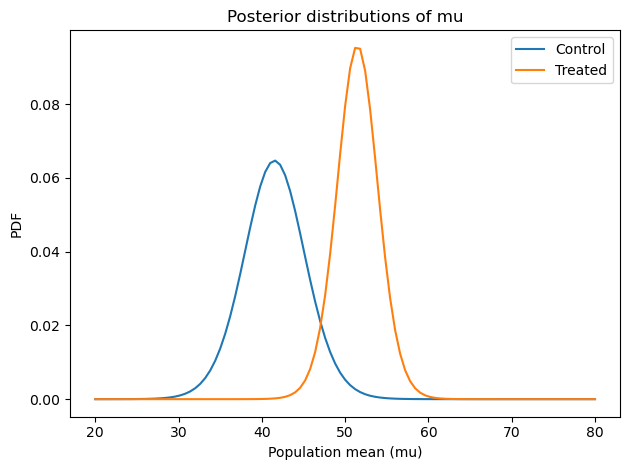

In [28]:
pmf_mean_control.plot(label='Control')
pmf_mean_treated.plot(label='Treated')

decorate(xlabel='Population mean (mu)', 
         ylabel='PDF', 
         title='Posterior distributions of mu')

In both cases the posterior probabilities at the ends of the range are near zero, which means that the bounds we chose for the prior distribution are wide enough.

Comparing the marginal distributions for the two groups, it looks like the population mean in the treated group is higher. We can use prob_gt to compute the probability of superiority:

In [30]:
p = ed.Pmf.prob_gt(pmf_mean_treated, pmf_mean_control)

print(f'Probability of higher mean in treated group: {p}')

Probability of higher mean in treated group: 0.980479025187326


### Distribution of Differences

We can use this to estimate intervat for improvement.

To quantify the magnitude of the difference between groups, we can use sub_dist to compute the distribution of the difference. There are two things to be careful about when you use methods like sub_dist. The first is that the result usually contains more elements than the original Pmf. 
In the worst case, the size of the result can be the product of the sizes of the originals.

In [31]:
pmf_diff = ed.Pmf.sub_dist(pmf_mean_treated, pmf_mean_control)

len(pmf_mean_treated), len(pmf_mean_control), len(pmf_diff)

(101, 101, 879)

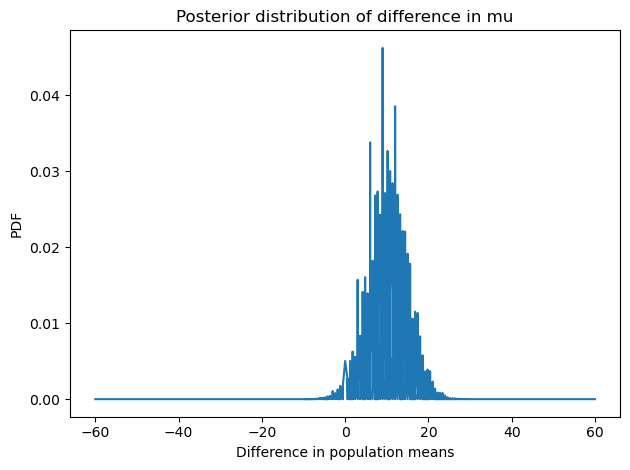

In [32]:
pmf_diff.plot()

decorate(xlabel='Difference in population means', 
         ylabel='PDF', 
         title='Posterior distribution of difference in mu')

quite noisy. 

There are two ways to work around that limitation. One is to plot the CDF, which smooths out the noise.

The other option is to use kernel density estimation (KDE) to make a smooth approximation of the PDF on an equally-spaced grid

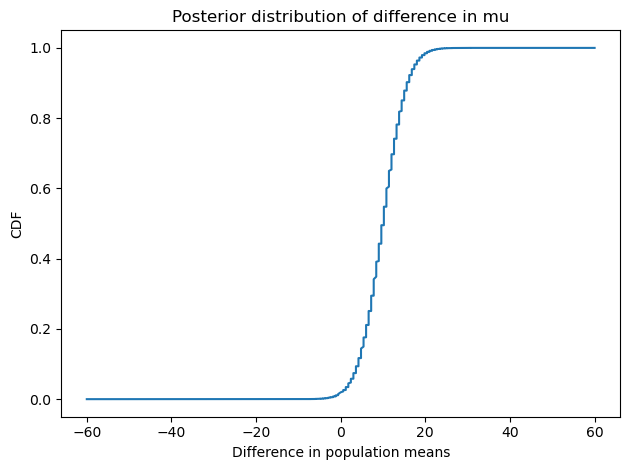

In [33]:
cdf_diff = pmf_diff.make_cdf()

cdf_diff.plot()

decorate(xlabel='Difference in population means', 
         ylabel='CDF', 
         title='Posterior distribution of difference in mu')

In [35]:
def kde_from_pmf(pmf, n=101):
    """Make a kernel density estimate for a PMF."""
    kde = s.gaussian_kde(pmf.qs, weights=pmf.ps)
    qs = np.linspace(pmf.qs.min(), pmf.qs.max(), n)
    ps = kde.evaluate(qs)
    pmf = ed.Pmf(ps, qs)
    pmf.normalize()
    return pmf

In [36]:
kde_diff = kde_from_pmf(pmf_diff)

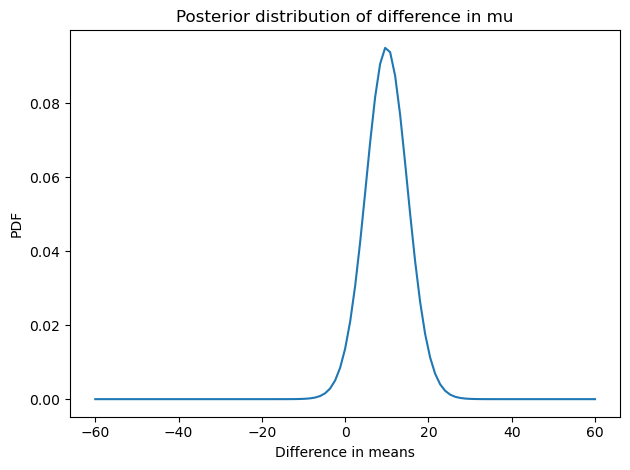

In [37]:
kde_diff.plot()

decorate(xlabel='Difference in means', 
         ylabel='PDF', 
         title='Posterior distribution of difference in mu')

In [39]:
m = pmf_diff.mean()
i_90 = pmf_diff.credible_interval(0.9)
i_95 = pmf_diff.credible_interval(0.95)
i_99 = pmf_diff.credible_interval(0.99)

print(f'Mean improvement: {m}')
print(f'Inreval 90%: {i_90}')
print(f'Inreval 95%: {i_95}')
print(f'Inreval 99%: {i_99}')

Mean improvement: 9.954413088940848
Inreval 90%: [ 2.4 17.4]
Inreval 95%: [ 0.6 19.2]
Inreval 99%: [-2.4 22.2]


### Summary statistics

The result is a 3-D array; for larger datasets, it might be too big to compute practically.

Also, with larger datasets the likelihoods get very small, sometimes so small that we can’t compute them with floating-point arithmetic. That’s because we are computing the probability of a particular dataset; the number of possible datasets is astronomically big, so the probability of any of them is very small.

An alternative is to compute a summary of the dataset and compute the likelihood of the summary. For example, if we compute the mean and standard deviation of the data, we can compute the likelihood of those summary statistics under each hypothesis.

Example:
As an example, suppose we know that the actual mean of the population, M, is 42 and the actual standard deviation, STD, is 17.

Now suppose we draw a sample from this distribution with sample size n=20, and compute the mean of the sample, which I’ll call m, and the standard deviation of the sample, which I’ll call s.

n=20, m=41, s=18

The summary statistics, m and s, are not too far from the parameters and M and STD, so it seems like they are not too unlikely.

To compute their likelihood, we will take advantage of three results from mathematical statistics:

 * Given M and STD, the distribution of m is normal with parameters M and STD/sqrt(n)
 * The distribution of s is more complicated, but if we compute the transform, t = n*s\**2/STD\**2, the distribution of t is chi-squared with parameter n-1 
 * According to Basu’s theorem, m and s are independent.

So let’s compute the likelihood of m and s given M, STD.

In [42]:
M = 42
STD = 17
m = 41
std = 18
n = 20

dist_m = s.norm(M, STD/n**0.5) # sampling distribution of a mean

In [43]:
t = n*std**2/STD**2
dist_s = s.chi2(n-1)

In [45]:
likelihood_m = dist_m.pdf(m)
likelihood_s = dist_s.pdf(t)

likelihood_m * likelihood_s # density != prob

0.004801750420548287

**Update**

In [47]:
summary = {}

for name, response in responses.items():
    summary[name] = len(response), response.mean(), response.std()
    
print(summary)

n, m, std = summary['Control']
mus, sigmas = np.meshgrid(prior.columns, prior.index)
mus.shape

{'Control': (23, 41.52173913043478, 17.148733229699484), 'Treated': (21, 51.476190476190474, 11.00735684721381)}


(101, 101)

In [51]:
# Now we can compute the likelihood of seeing the sample mean, m, for each pair of parameters.
like1 = s.norm(mus, sigmas/np.sqrt(n)).pdf(m)
like1.shape

(101, 101)

In [52]:
# And we can compute the likelihood of the sample standard deviation, s, for each pair of parameters.
ts = n * std**2 / sigmas**2
like2 = s.chi2(n-1).pdf(ts)
like2.shape

(101, 101)

In [56]:
# Finally, we can do the update with both likelihoods
posterior_control2 = prior * like1 * like2
normalize(posterior_control2)

0.0003227416100585113

In [57]:
def update_norm_summary(prior, data):
    """Update a normal distribution using summary statistics."""
    n, m, std = data
    mu_mesh, sigma_mesh = np.meshgrid(prior.columns, prior.index)
    
    like1 = s.norm(mu_mesh, sigma_mesh/np.sqrt(n)).pdf(m)
    like2 = s.chi2(n-1).pdf(n * std**2 / sigma_mesh**2)
    
    posterior = prior * like1 * like2
    normalize(posterior)
    
    return posterior

In [58]:
data = summary['Treated']
posterior_treated2 = update_norm_summary(prior, data)

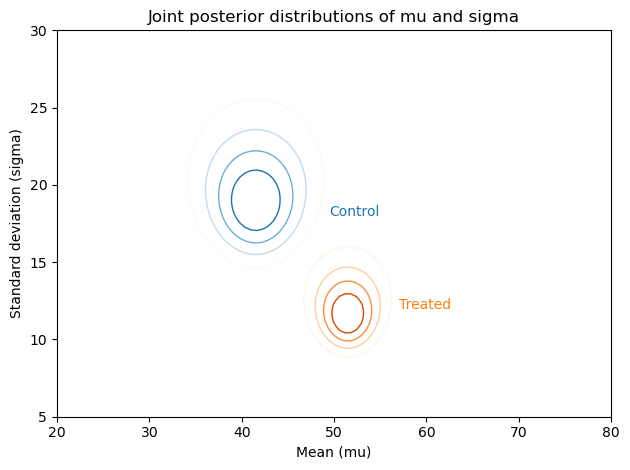

In [59]:
plot_contour(posterior_control2, cmap='Blues')
plt.text(49.5, 18, 'Control', color='C0')

cs = plot_contour(posterior_treated2, cmap='Oranges')
plt.text(57, 12, 'Treated', color='C1')

decorate(xlabel='Mean (mu)', 
         ylabel='Standard deviation (sigma)',
         title='Joint posterior distributions of mu and sigma')

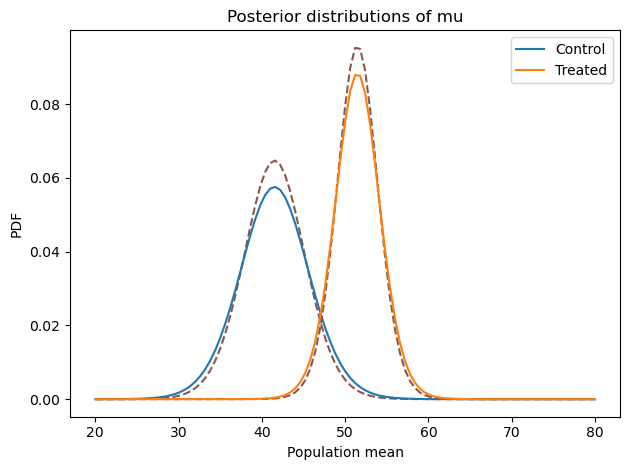

In [60]:
pmf_mean_control2 = marginal(posterior_control2, 0)
pmf_mean_treated2 = marginal(posterior_treated2, 0)

pmf_mean_control.plot(color='C5', ls='--')
pmf_mean_control2.plot(label='Control')
pmf_mean_treated.plot(color='C5', ls='--')
pmf_mean_treated2.plot(label='Treated')

decorate(xlabel='Population mean', 
         ylabel='PDF', 
         title='Posterior distributions of mu')

In [62]:
p = ed.Pmf.prob_gt(pmf_mean_treated2, pmf_mean_control2)

print(f'Probability of higher mean in treated group: {p}')

Probability of higher mean in treated group: 0.9687800887506524


In [63]:
pmf_diff = ed.Pmf.sub_dist(pmf_mean_treated2, pmf_mean_control2)

m = pmf_diff.mean()
i_90 = pmf_diff.credible_interval(0.9)
i_95 = pmf_diff.credible_interval(0.95)
i_99 = pmf_diff.credible_interval(0.99)

print(f'Mean improvement: {m}')
print(f'Inreval 90%: {i_90}')
print(f'Inreval 95%: {i_95}')
print(f'Inreval 99%: {i_99}')

Mean improvement: 9.954290602803232
Inreval 90%: [ 1.2 18.6]
Inreval 95%: [ 0.  20.4]
Inreval 99%: [-3.6 23.4]


The posterior distributions based on summary statistics are similar to the posteriors we computed using the entire dataset, but in both cases they are shorter and a little wider.

That’s because the update with summary statistics is based on the implicit assumption that the distribution of the data is normal. But it’s not; as a result, when we replace the dataset with the summary statistics, we lose some information about the true distribution of the data. With less information, we are less certain about the parameters.

In [86]:
dist_M = s.norm(M, STD).pdf(np.linspace(0,100,300))
population = ed.Pmf(dist_M, np.linspace(0,100,300))
population.normalize()
population

,probs
0.000000,0.000374
0.334448,0.000392
0.668896,0.000411
1.003344,0.000431
1.337793,0.000452
...,...
98.662207,0.000031
98.996656,0.000029
99.331104,0.000027
99.665552,0.000025


In [87]:
ed.Pmf.prob_gt(population, pmf_mean_control2), ed.Pmf.prob_gt(pmf_mean_treated2, population)

(0.5140174349518434, 0.707152574612679)

<AxesSubplot:>

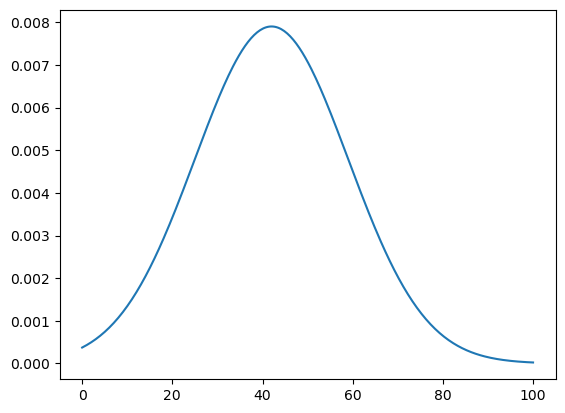

In [88]:
population.plot()

In [92]:
population.credible_interval(0.1), population.mean()

(array([40.13377926, 44.14715719]), 42.29541391441788)

### Proof by simulation

The update with summary statistics is based on theoretical distributions, and it seems to work, but I think it is useful to test theories like this, for a few reasons:

 * It confirms that our understanding of the theory is correct,

 * It confirms that the conditions where we apply the theory are conditions where the theory holds,

 * It confirms that the implementation details are correct. For many distributions, there is more than one way to specify the parameters. If you use the wrong specification, this kind of testing will help you catch the error.


**Mean**

In [93]:
# suppose we know population parameters from previous example. The pop dist is:
dist = s.norm(M, STD)

In [94]:
# we can generate samples
samples = dist.rvs((1000, n))

sample_means = samples.mean(axis=1)

In [96]:
def pmf_from_dist(dist, low, high):
    """Make a discrete approximation of a continuous distribution.
    
    dist: SciPy dist object
    low: low end of range
    high: high end of range
    
    returns: normalized Pmf
    """
    qs = np.linspace(low, high, 101)
    ps = dist.pdf(qs)
    pmf = ed.Pmf(ps, qs)
    pmf.normalize()
    return pmf

In [97]:
low = dist_m.mean() - dist_m.std() * 3
high = dist_m.mean() + dist_m.std() * 3

pmf_m = pmf_from_dist(dist_m, low, high)

In [98]:
from utils import kde_from_sample

qs = pmf_m.qs
pmf_sample_means = kde_from_sample(sample_means, qs)

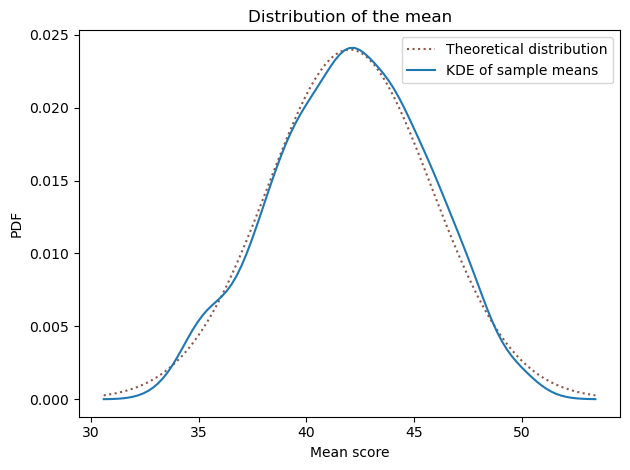

In [99]:
pmf_m.plot(label='Theoretical distribution',
           ls=':', color='C5')
pmf_sample_means.plot(label='KDE of sample means')

decorate(xlabel='Mean score',
         ylabel='PDF',
         title='Distribution of the mean')

**Standard deviation**

In [100]:
sample_stds = samples.std(axis=1)

transformed = n * sample_stds**2 / STD**2
dist_s = s.chi2(n-1)

low = 0
high = dist_s.mean() + dist_s.std() * 4

pmf_s = pmf_from_dist(dist_s, low, high)

qs = pmf_s.qs
pmf_sample_stds = kde_from_sample(transformed, qs)

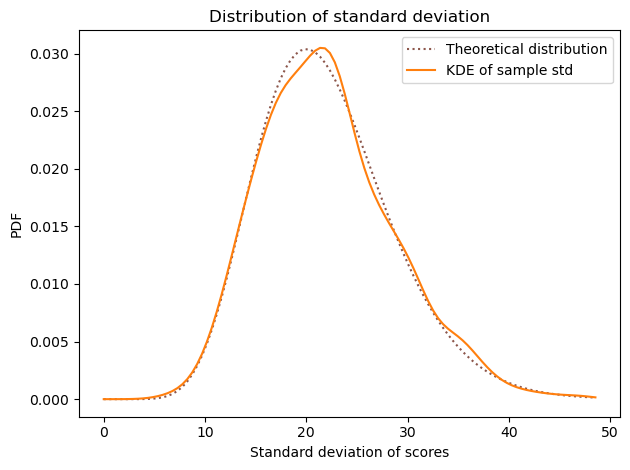

In [101]:
pmf_s.plot(label='Theoretical distribution',
           ls=':', color='C5')
pmf_sample_stds.plot(label='KDE of sample std',
                     color='C1')

decorate(xlabel='Standard deviation of scores',
         ylabel='PDF',
         title='Distribution of standard deviation')

**Independence mu, std**

In [102]:
np.corrcoef(sample_means, sample_stds)

array([[ 1.        , -0.02490866],
       [-0.02490866,  1.        ]])

In [103]:
dist_gamma = s.gamma(20)

In [111]:
samples_g = dist_gamma.rvs((1000, 20))

ms = samples_g.mean(axis=1)
stds = samples_g.std(axis=1)

<AxesSubplot:>

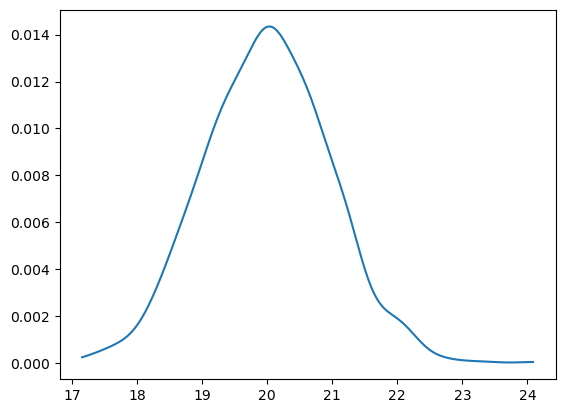

In [112]:
kde_from_sample(ms, np.linspace(ms.min(), ms.max(), 200)).plot()

<AxesSubplot:>

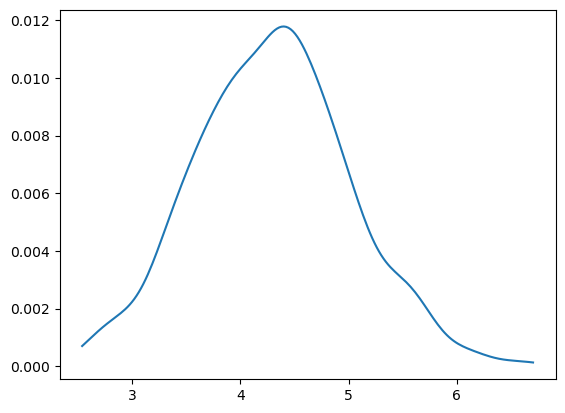

In [113]:
kde_from_sample(stds, np.linspace(stds.min(), stds.max(), 200)).plot()

In [114]:
np.corrcoef(ms, stds)

array([[1.        , 0.27758839],
       [0.27758839, 1.        ]])

### Exercises

Extract the marginal posterior distributions of sigma for the two groups. What is the probability that the standard deviation is higher in the control group?

Compute the distribution of the difference in sigma between the two groups. What is the mean of this difference? What is the 90% credible interval?

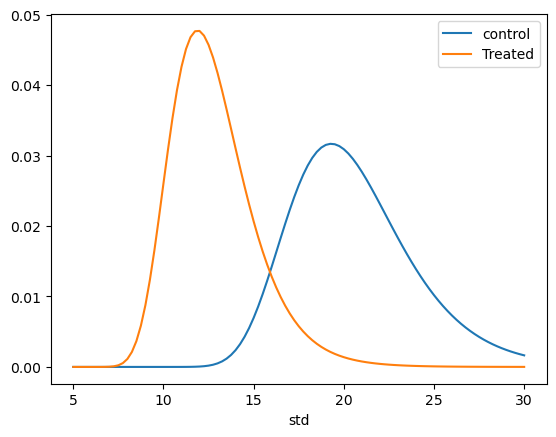

In [115]:
control_std = marginal(posterior_control2, 1)
treated_std = marginal(posterior_treated2, 1)

control_std.plot(label='control')
treated_std.plot(label='Treated')
plt.legend()

In [116]:
ed.Pmf.prob_ge(control_std, treated_std)

0.9758023817350517

In [117]:
diff = ed.Pmf.sub_dist(control_std, treated_std)
diff.shape

(201,)

<AxesSubplot:>

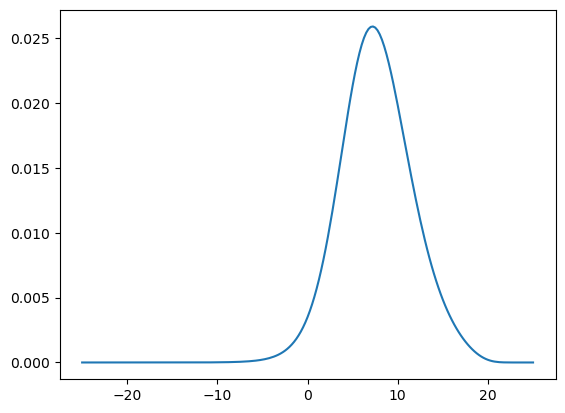

In [124]:
diff.plot()

In [125]:
diff.credible_interval(0.9)

array([ 1.25, 14.5 ])

An effect size is a statistic intended to quantify the magnitude of a phenomenon. If the phenomenon is a difference in means between two groups, a common way to quantify it is Cohen’s effect size, denoted, d.

If the parameters for Group 1 are (m1, s1), and the parameters for Group 2 are (m2, s2), Cohen’s effect size is:
d = (m1-m2)/((s1+s2)/2) or pooled stdev for not paired test.

In [126]:
def sample_joint(joint, size):
    """Draw a sample from a joint distribution.
    
    joint: DataFrame representing a joint distribution
    size: sample size
    """
    pmf = ed.Pmf(joint.transpose().stack())
    return pmf.choice(size)

In [127]:
sample_treated = sample_joint(posterior_treated, 1000)
sample_control = sample_joint(posterior_control, 1000)
sample_control[0]

(48.8, 17.25)

In [128]:
def cohen_effect(pair1, pair2):
    """Compute Cohen's effect size for difference in means.
    
    pair1: tuple of (mu1, sigma1)
    pair2: tuple of (mu2, sigma2)
    
    return: float
    """
    mu1, sigma1 = pair1 
    mu2, sigma2 = pair2
    sigma = (sigma1 + sigma2) / 2
    return (mu1 - mu2) / sigma

In [129]:
coefs = []
for p1, p2 in zip(sample_control, sample_treated):
    coef = cohen_effect(p1, p2)
    coefs.append(coef)

<AxesSubplot:>

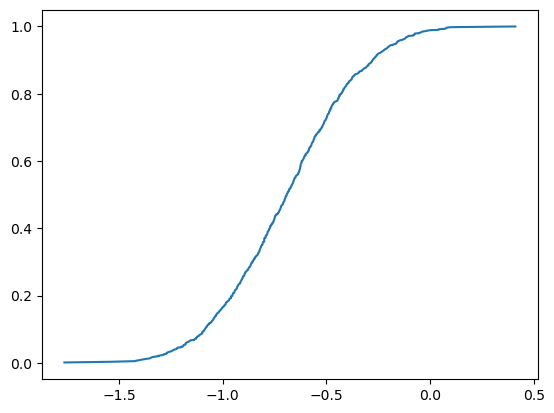

In [130]:
cdf = ed.Cdf.from_seq(coefs)
cdf.plot()

In [131]:
print(cdf.mean())
print(cdf.credible_interval(0.9)) # small to large magnitude od difference https://en.wikipedia.org/wiki/Effect_size

-0.6890761017576793
[-1.19008264 -0.16271186]


An instructor announces the results of an exam like this, “The average score on this exam was 81. Out of 25 students, 5 got more than 90, and I am happy to report that no one failed (got less than 60).”

Based on this information, what do you think the standard deviation of scores was?

In [188]:
m = 81
stds = np.linspace((81-61)/10, 50, 100) # 30 after trial

In [189]:
dist = s.norm(m, stds)

pmf = ed.Pmf(1, stds)

<AxesSubplot:>

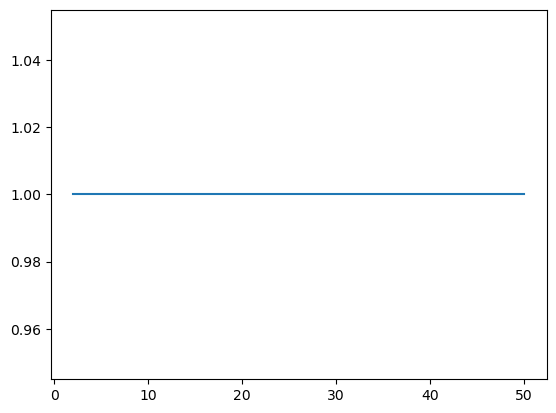

In [190]:
pmf.plot()

In [191]:
# likelihood that 5 people exceeded 90
l1 = s.binom(25, dist.sf(90)).pmf(5)

In [192]:
# likelihood 25 students above 60 points
p = dist.sf(60)

print((p**25).sum())
print(s.binom(25, p).pmf(25).sum())

20.006504262699185
20.006504262699185


In [193]:
likelihood = l1 * p**25

In [194]:
posterior = pmf * likelihood
posterior.normalize()

1.4847003521762983

<AxesSubplot:>

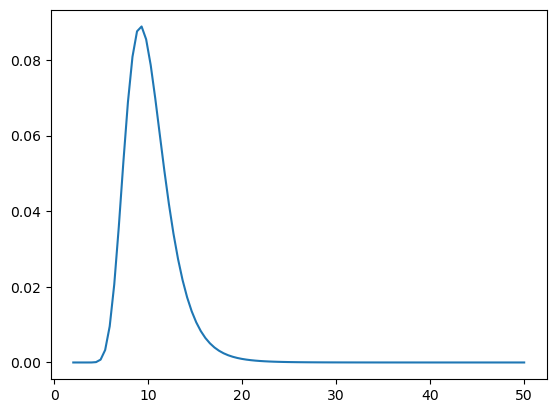

In [195]:
posterior.plot()

In [196]:

posterior.mean(), posterior.credible_interval(0.9)

(10.189689542827475, array([ 6.84848485, 14.60606061]))

Use these summary statistics to compute the posterior distribution of mu and sigma for the distributions of male and female height. Use Pmf.div_dist to compute posterior distributions of CV. Based on this dataset and the assumption that the distribution of height is normal, what is the probability that the coefficient of variation is higher for men? What is the most likely ratio of the CVs and what is the 90% credible interval for that ratio?

In [215]:
m_men, m_women = 178, 163
std_men, std_women = 8.27, 7.75
n_men, n_women = 154407, 254722

heights = np.linspace(130, 225, 201)
stds = np.linspace(3, 30, 101)

In [247]:
prior_men = make_joint(
    ed.Pmf.from_seq(np.linspace(160, 185, 101), name='mean'),
    ed.Pmf.from_seq(np.linspace(6, 10, 101), name='stds')
)
prior_women = make_joint(
    ed.Pmf.from_seq(np.linspace(150, 175, 201), name='mean'),
    ed.Pmf.from_seq(np.linspace(6, 10, 101), name='stds')
)

In [248]:
posterior_men = update_norm_summary(prior_men, (n_men, m_men, std_men))
posterior_women = update_norm_summary(prior_women, (n_women, m_women, std_women))

In [249]:
(posterior_men==np.inf).sum().sum()

0

In [250]:
def get_posterior_cv(joint):
    """Get the posterior distribution of CV.
    
    joint: joint distribution of mu and sigma
    
    returns: Pmf representing the smoothed posterior distribution
    """
    pmf_mu = marginal(joint, 0)
    pmf_sigma = marginal(joint, 1)
    pmf_cv = ed.Pmf.div_dist(pmf_sigma, pmf_mu)
    return kde_from_pmf(pmf_cv)

In [251]:
cv_men = get_posterior_cv(posterior_men)
cv_women = get_posterior_cv(posterior_women)

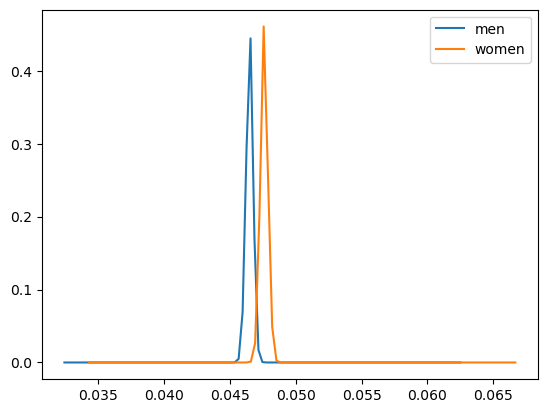

In [252]:
kde_from_pmf(cv_men).plot(label='men')
kde_from_pmf(cv_women).plot(label='women')
plt.legend()

In [253]:
ed.Pmf.prob_ge(cv_men, cv_women)

1.8028645908133885e-07

In [254]:
cv_ratio = ed.Pmf.div_dist(cv_men, cv_women)

In [256]:
cv_ratio.credible_interval(0.9), cv_ratio.max_prob()

(array([0.96612349, 0.98573384]), 0.9790228003333731)